# 필요 라이브러리

In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
# 필요 라이브러리
import plotly
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from plotly.validators.scatter.marker import SymbolValidator
import pandas as pd

In [3]:
!pip install konlpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import sequence
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import os
import tempfile

In [5]:
!apt-get install g++ openjdk-8-jdk 
!pip3 install konlpy JPype1-py3
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

Reading package lists... Done
Building dependency tree       
Reading state information... Done
g++ is already the newest version (4:7.4.0-1ubuntu2.3).
openjdk-8-jdk is already the newest version (8u292-b10-0ubuntu1~18.04).
0 upgraded, 0 newly installed, 0 to remove and 44 not upgraded.
mecab-ko is already installed
mecab-ko-dic is already installed
mecab-python is already installed
Done.


# 긍정, 부정을 새로 직접 라벨링한 별점 2~4점 리뷰데이터 + 별점 기반 1, 5점 리뷰데이터 합치기

In [6]:
# 라벨링 새로한 리뷰 1가져오기
label1_url = '/content/drive/MyDrive/Colab Notebooks/yanolja/data/Part1_jeju_hotel_2_4_token.xlsx'
ed_df1 = pd.read_excel(label1_url)
# 카피본만들기
copy_df1 = ed_df1.copy()
# 라벨링 새로한 리뷰 2가져오기
label2_url = '/content/drive/MyDrive/Colab Notebooks/yanolja/data/Part2_jeju_hotel_2_4_token.xlsx'
ed_df2 = pd.read_excel(label2_url)
# 카피본만들기
copy_df2 = ed_df2.copy()
# 1-5점 리뷰 가져오기
star1_5_url = '/content/drive/MyDrive/Colab Notebooks/yanolja/data/jeju_hotel_1_5_tokens_train.xlsx'
ed_df3 = pd.read_excel(star1_5_url)
# 카피본만들기
copy_df3 = ed_df3.copy()

In [7]:
merged_df = pd.concat([copy_df1, copy_df2, copy_df3])

In [8]:
#데이터프레임 카피본
combined_df = merged_df.copy()

In [9]:
# feature engineering
combined_df = combined_df.drop(['Unnamed: 0', 'Code', 'date', 'helpful', 'preprocessed_review', 'review', 'star', 'star_label'], axis=1)

In [10]:
combined_df

,hotel,sentiment,separate_review
0,NaN,NaN,NaN
1,더 베스트 제주 성산(구 라마다 앙코르 성산),1.0,직원분들 친절하고 좋았고요 가격은 싼 거 같 조식도 깔끔했고요
2,더 베스트 제주 성산(구 라마다 앙코르 성산),0.0,호텔이 낡아서 그런지 카펫과 에어컨에서 쾌쾌한 냄새가 많이 났고 천장 환풍기에 까...
3,더 베스트 제주 성산(구 라마다 앙코르 성산),0.0,샤워실 바닥 유리 쪽에도 까만 곰팡이가 많이 보였
4,더 베스트 제주 성산(구 라마다 앙코르 성산),0.0,커튼도 많이 더러웠고 방충망에 구멍이 뚫려 있어서 제가 반창고로 막아서 사용했
...,...,...,...
11560,휘슬락 호텔,1.0,와이파이랑 다시 보기가 없
11561,휘슬락 호텔,1.0,오오 엄청 깔끔하고 바다 경치 진짜 좋
11562,히든 클리프 호텔 앤 네이쳐,1.0,직원분들도 친절하시고요 와이파이는 설치해주세요 오 산꼭대기 목장에도 와이파이가 있는데
11563,히든 클리프 호텔 앤 네이쳐,1.0,숙소도 깨끗하고 고급스럽고 수영장 물 온도도 적당하고 너무 예뻐요 조식도 맛있어요 ...


In [11]:
# separate_review, sentiment 칼럼의 결측치만 제거
combined_df = combined_df[combined_df['separate_review'].notnull()]
combined_df = combined_df[combined_df['sentiment'].notnull()]

In [12]:
# sentiment 칼럼에서 중립 혹은 의미없는 값 2, 잘못 라벨링된 '21' 값 행 모두 제거
combined_df.drop(combined_df.loc[combined_df['sentiment']==2].index, inplace=True)
combined_df.drop(combined_df.loc[combined_df['sentiment']==21].index, inplace=True)

In [13]:
print(combined_df.isnull().sum())

hotel              1106
sentiment             0
separate_review       0
dtype: int64


In [14]:
combined_df

,hotel,sentiment,separate_review
1,더 베스트 제주 성산(구 라마다 앙코르 성산),1.0,직원분들 친절하고 좋았고요 가격은 싼 거 같 조식도 깔끔했고요
2,더 베스트 제주 성산(구 라마다 앙코르 성산),0.0,호텔이 낡아서 그런지 카펫과 에어컨에서 쾌쾌한 냄새가 많이 났고 천장 환풍기에 까...
3,더 베스트 제주 성산(구 라마다 앙코르 성산),0.0,샤워실 바닥 유리 쪽에도 까만 곰팡이가 많이 보였
4,더 베스트 제주 성산(구 라마다 앙코르 성산),0.0,커튼도 많이 더러웠고 방충망에 구멍이 뚫려 있어서 제가 반창고로 막아서 사용했
5,더 베스트 제주 성산(구 라마다 앙코르 성산),0.0,침대에 배드 버그가 있는지 물리고 간지러워 잠을 거의 못 잤
...,...,...,...
11560,휘슬락 호텔,1.0,와이파이랑 다시 보기가 없
11561,휘슬락 호텔,1.0,오오 엄청 깔끔하고 바다 경치 진짜 좋
11562,히든 클리프 호텔 앤 네이쳐,1.0,직원분들도 친절하시고요 와이파이는 설치해주세요 오 산꼭대기 목장에도 와이파이가 있는데
11563,히든 클리프 호텔 앤 네이쳐,1.0,숙소도 깨끗하고 고급스럽고 수영장 물 온도도 적당하고 너무 예뻐요 조식도 맛있어요 ...


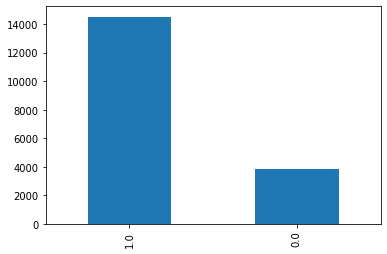

In [15]:
combined_df['sentiment'].value_counts().plot(kind = 'bar')

In [16]:
# 긍정부정 라벨링으로 descending order로 분류해 재정렬하기 -> 나중에 stratify를 사용해 긍정과 부정의 비율을 맞추기 위함
combined_df = combined_df.sort_values(by='sentiment', ascending=False)
# 인덱스 재조정
combined_df = combined_df.reset_index()
# 예전 인덱스 칼럼 드랍
combined_df = combined_df.drop(['index'], axis=1)
# 데이터프레임 카피본
labeled_df = combined_df.copy()

In [17]:
labeled_df

,hotel,sentiment,separate_review
0,더 베스트 제주 성산(구 라마다 앙코르 성산),1.0,직원분들 친절하고 좋았고요 가격은 싼 거 같 조식도 깔끔했고요
1,아트스테이 서귀포 하버,1.0,야 놀자 통해서 쿠폰 쓰고 정면 오션경치를 저렴하게 구매해서 잘 지내다 왔습니다 엘...
2,아트스테이 서귀포 하버,1.0,이중섭거리랑 가깝고 유동 커피와도 가깝
3,아트스테이 서귀포 하버,1.0,호텔 안에 편의점은 없으며 근처 옆 건물에 편의점 있
4,아트스테이 서귀포 하버,1.0,정면 오션경치이지만 호텔이 위치상 바다 바로 앞은 아니어서 사진처럼 마을이 보이고...
...,...,...,...
18360,에벤에셀 제주 함덕호텔,0.0,바람이 무척 부는 날 이틀 묵었
18361,에벤에셀 제주 함덕호텔,0.0,바람소리가 창문을 흔들어서 잠이 잘 오지 않았
18362,에벤에셀 제주 함덕호텔,0.0,그 다음날은 바람이 불지 않았고 창문도 흔들리지 않아 편안하게 잠들었
18363,에벤에셀 제주 함덕호텔,0.0,모든 객실의 창문이 바람에 그렇게 흔들린다고 하니 참고하시길


# 데이터셋 나누기

In [18]:
# train | test 데이터로 분리  
train_data, test_data = train_test_split(labeled_df, test_size=0.3, shuffle=True, stratify=labeled_df['sentiment'], random_state=50)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 12855
테스트용 리뷰의 개수 : 5510


### 긍정 라벨링 1, 부정 라벨링 0 의 분포 확인
- 한 클래스가 다른 클래스보다 훨씬 많은 불균형 데이터 셋

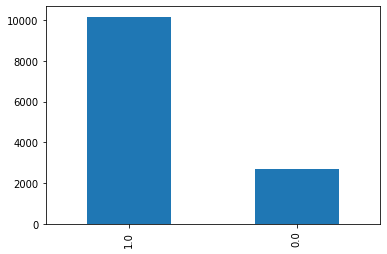

In [19]:
train_data['sentiment'].value_counts().plot(kind = 'bar')

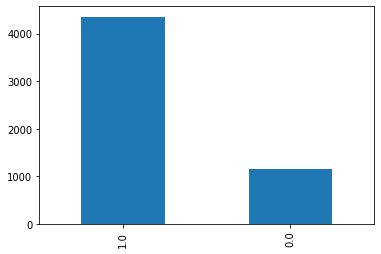

In [20]:
test_data['sentiment'].value_counts().plot(kind = 'bar')

# Mecab을 이용한 토큰화

In [21]:
from konlpy.tag import Mecab
mecab = Mecab()

In [22]:
# Train data에 mecab 적용
train_data['tokenized']  = train_data['separate_review'].apply(mecab.morphs)
# Test data에 mecab 적용
test_data['tokenized'] = test_data['separate_review'].apply(mecab.morphs)

# 단어와 길이 분포 확인

In [23]:
# 부정 키워드, 긍정 키워드
negative_words = np.hstack(train_data[train_data.sentiment == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.sentiment == 1]['tokenized'].values)

긍정 리뷰의 평균 길이 : 16.748917748917748
부정 리뷰의 평균 길이 : 21.557413600891863


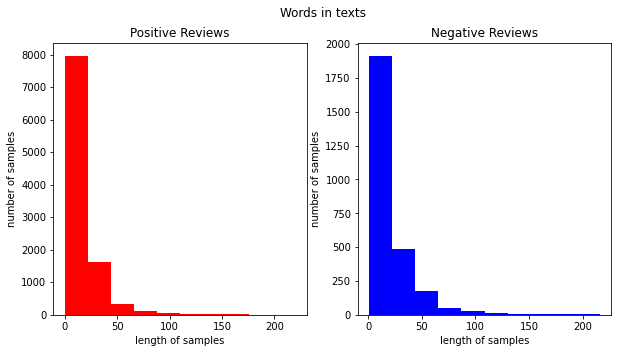

In [24]:
# 긍정/부정 리뷰별 평균 길이 비교
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['sentiment']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['sentiment']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

### 각각의 X_train, y_train, X_test, y_test에 직접 지정

In [25]:
X_train = train_data['tokenized'].values
y_train = train_data['sentiment'].values
X_test= test_data['tokenized'].values
y_test = test_data['sentiment'].values

# 단어 기반 인코딩
- 텍스트를 숫자로 처리하도록 training data, test data에 tokenizer 적용

In [26]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [27]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받음
for key, value in tokenizer.word_counts.items():
  total_freq = total_freq + value

  # 단어의 등장 빈도수가 threshold보다 작을 때
  if (value < threshold):
    rare_cnt = rare_cnt + 1
    rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 6585
등장 빈도가 1번 이하인 희귀 단어의 수: 1852
단어 집합에서 희귀 단어의 비율: 28.12452543659833
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.811401683264183


In [28]:
# 희귀 단어 제외 단어 집합 크기
# 0,1번 empty값, OOV 토큰 고려, +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 4735


### 시퀀스로 변환

In [29]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [30]:
print(X_train[:3])

[[82, 7, 71, 10, 19, 682, 71, 56, 5, 572], [344, 218, 14, 16, 104, 12, 1100, 86, 102, 3, 8, 15, 651, 5, 2, 381, 114], [517, 11, 285, 291, 885, 1896, 12, 14, 38, 133, 11]]


In [31]:
print(X_test[:3])

[[74, 252, 262, 7, 11, 28, 165, 12, 3, 22, 67, 52], [79, 10, 1, 61, 207, 1209, 1567, 89, 43, 3, 12, 67, 52], [966, 6, 3, 115, 49, 69, 143, 21, 94, 45, 173, 473, 14, 16, 1, 89, 43, 212, 117, 45, 2724, 1, 81, 4, 1053, 1002, 151, 10, 920, 19, 368, 16, 32, 34, 33, 4, 340, 1, 5, 2, 349, 26, 151, 10, 1366, 22, 4637, 7, 105, 137, 1968, 744, 43, 528, 10, 1852, 18]]


### 리뷰길이 조정을 위한 패딩

리뷰의 최대 길이 : 220
리뷰의 평균 길이 : 17.755503695060288


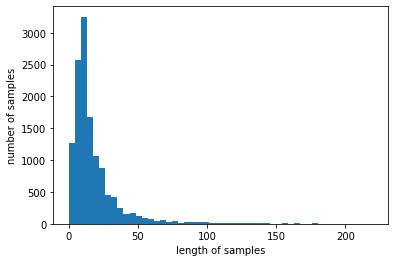

In [32]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

### 위에서 그래프를 본 결과 60을 max_len으로 지정

In [33]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [34]:
max_len = 60
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 60 이하인 샘플의 비율: 96.67055620381174


In [35]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

## X_train과 y_train --> train & validation dataset으로 나누기

In [36]:
x_train_tmp, x_val, y_train_tmp, y_val = train_test_split(X_train, y_train, test_size=0.3, shuffle=True, stratify=y_train, random_state=20)

In [37]:
x_train_tmp.shape, x_val.shape, y_train_tmp.shape, y_val.shape

((8998, 60), (3857, 60), (8998,), (3857,))

# LSTM과 클래스 가중치로 모델 교육
- 부정리뷰의 수가 긍정리뷰에 비해 현저히 작아 불균형이 심하므로 부정리뷰에 가중치 부여

### Step 1. 클래스 가중치 계산

In [38]:
neg, pos = np.bincount(labeled_df['sentiment'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Examples:
    Total: 18365
    Positive: 14520 (79.06% of total)

Weight for class 0: 2.39
Weight for class 1: 0.63


### Step 2. 모델 구조 설계

In [39]:
model = Sequential()
model.add(layers.Embedding(vocab_size, 64))
model.add(layers.Bidirectional(layers.LSTM(120)))
model.add(layers.Dense(1, activation='sigmoid'))

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          303040    
_________________________________________________________________
bidirectional (Bidirectional (None, 240)               177600    
_________________________________________________________________
dense (Dense)                (None, 1)                 241       
Total params: 480,881
Trainable params: 480,881
Non-trainable params: 0
_________________________________________________________________


In [41]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

### Step 3. 모델에 필요한 설정정보 세팅

In [42]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

### Step 4. 클래스 가중치로 모델 학습

In [43]:
weighted_history = model.fit(x_train_tmp, y_train_tmp, 
                              epochs=15, 
                              callbacks=[es, mc],
                              batch_size=60,
                              validation_data= (x_val, y_val),
                              class_weight=class_weight)

Epoch 1/15
150/150 [==============================] - 12s 49ms/step - loss: 0.4512 - acc: 0.8062 - val_loss: 0.5386 - val_acc: 0.8035

Epoch 00001: val_acc improved from -inf to 0.80347, saving model to best_model.h5
Epoch 2/15
150/150 [==============================] - 6s 42ms/step - loss: 0.2721 - acc: 0.8806 - val_loss: 0.2805 - val_acc: 0.8901

Epoch 00002: val_acc improved from 0.80347 to 0.89007, saving model to best_model.h5
Epoch 3/15
150/150 [==============================] - 6s 42ms/step - loss: 0.2317 - acc: 0.8962 - val_loss: 0.2792 - val_acc: 0.8924

Epoch 00003: val_acc improved from 0.89007 to 0.89240, saving model to best_model.h5
Epoch 4/15
150/150 [==============================] - 6s 42ms/step - loss: 0.2086 - acc: 0.9050 - val_loss: 0.2385 - val_acc: 0.9069

Epoch 00004: val_acc improved from 0.89240 to 0.90692, saving model to best_model.h5
Epoch 5/15
150/150 [==============================] - 6s 42ms/step - loss: 0.1893 - acc: 0.9129 - val_loss: 0.4017 - val_acc: 

In [44]:
loaded_model = load_model('best_model.h5')
print("\n Best Model의 성능: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

173/173 [==============================] - 3s 12ms/step - loss: 0.2617 - acc: 0.9103

 Best Model의 성능: 0.9103


# 학습을 바탕으로 리뷰 긍/부정 라벨링 시키기

### 새로운 텍스트로 분류시켜보기 위해 라벨링되지 않은 리뷰 데이터 불러오기

In [45]:
# 어미 어근으로 분리된 리뷰 데이터 불러오기;
test_url = '/content/drive/MyDrive/Colab Notebooks/yanolja/data/jeju_hotel_tokens_test.xlsx'
new = pd.read_excel(test_url)
# 카피본만들기
unlabeled_df = new.copy()

In [46]:
# 결측값 확인 및 feature engineering
print(unlabeled_df.isnull().sum())
unlabeled_df = unlabeled_df.drop(['Unnamed: 0', 'Code', 'review', 'date'], axis=1)

Unnamed: 0             0
Code                   0
hotel                  0
star                   0
review                 0
preprocessed_review    0
date                   0
separate_review        0
dtype: int64


In [47]:
# 긍정부정 라벨링으로 descending order로 분류해 재정렬하기 -> 나중에 stratify를 사용해 긍정과 부정의 비율을 맞추기 위함
unlabeled_df = unlabeled_df.sort_values(by='star', ascending=False)
# 인덱스 재조정
unlabeled_df = unlabeled_df.reset_index()
# 예전 인덱스 칼럼 드랍
unlabeled_df = unlabeled_df.drop(['index'], axis=1)
# 데이터프레임 카피본
unlabeled = unlabeled_df.copy()

In [48]:
unlabeled

,hotel,star,preprocessed_review,separate_review
0,아트스테이 서귀포 하버,5,조용하고 좋아요 주변에 편의점이랑 주차장 올레시장 다 걸어서 갈수 있어서 좋아요,조용하고 좋아요 주변에 편의점이랑 주차장 올레시장 다 걸어서 갈수 있어서 좋아요
1,호텔 케니 서귀포,5,도보로 분 거리에 올레시장이 있어 무척이나 좋았습니다 비가 와서 예상보다 체크인을...,서비스 친절도는 잘 모르겠고 수건도 하루에 최대 장 밖에 추가 안되고 방은 좁지만 ...
2,호텔 케니 서귀포,5,서귀포 쭉 가면 이용하는 곳이에요 좀 좁은 감은 있어도 전혀 무리 없습니다,서귀포 쭉 가면 이용하는 곳이에요 좀 좁은 감은 있어도 전혀 무리 없습니다
3,호텔 케니 서귀포,5,서귀포 쭉 가면 이용하는 곳이에요 좀 좁은 감은 있어도 전혀 무리 없습니다,서귀포 쭉 가면 이용하는 곳이
4,호텔 케니 서귀포,5,서귀포 쭉 가면 이용하는 곳이에요 좀 좁은 감은 있어도 전혀 무리 없습니다,좀 좁은 감은 있어도 전혀 무리 없
...,...,...,...,...
16592,호텔 케니 서귀포,1,주차시설 협소 위생더럽 특히나 침대 시트 진짜 찝찝하고요 모기 많고요 진심 어디서 ...,방음 처리도 안 좋
16593,호텔 케니 서귀포,1,주차시설 협소 위생더럽 특히나 침대 시트 진짜 찝찝하고요 모기 많고요 진심 어디서 ...,펼쳐지지 않
16594,에벤에셀 제주 함덕호텔,1,오늘 박 째입니다 여기 박으로 예약한 진심 후회합니다 직원분들 폰 하기 바빠서 ...,네요 일반 모텔보다 못한 시설에 욕실 세면기는 고장입니다 이곳이 왜 호텔인지 의문스럽
16595,더큐브 리조트 제주,1,청결 상태 최악입니다 대충 눈에 보이는 곳만 청소하는지 여기저기 머리카락에 먼...,청결 상태 최악입니다 대충 눈에 보이는 곳만 청소하는지 여기저기 머리카락에 먼...


In [49]:
# 함수 생성
def weighted_predict(new_sentence):
  global score
  mec_sentence = mecab.morphs(new_sentence) #토큰화
  encoded = tokenizer.texts_to_sequences([mec_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{}. {} : {:.2f}% 확률로 긍정 리뷰입니다.".format(count, new_sentence, score * 100))
  else:
    #merged_df['sentiment'][count] = '부정'
    print("{}. {} : {:.2f}% 확률로 부정 리뷰입니다.".format(count, new_sentence, (1 - score) * 100))

In [50]:
# separate_review에 함수 적용 -> 새로운 테스트 데이터에 긍정=1 부정=0 라벨링하기
unlabeled['sentiment']=0
count=0
for new_review in unlabeled['separate_review']:
  weighted_predict(new_review)
  unlabeled['sentiment'][count] = np.select([score > 0.5], ['1'], default='0')
  count+=1

Streaming output truncated to the last 5000 lines.
11597.  연 박시 방 청소는 유료입니다 코인세탁이 호텔 내에 있 : 99.44% 확률로 부정 리뷰입니다.
11598.  빨래는 후딱 말라요 침대는 편하고 직원은 친절하셨지만 뭔가 계속 하나씩 부족해요  : 96.47% 확률로 부정 리뷰입니다.
11599.  객실도 넓고 또 올 수 더 있을 거 같아 묘 : 98.61% 확률로 긍정 리뷰입니다.
11600.  접근성이 좋 : 94.50% 확률로 긍정 리뷰입니다.
11601. 공항 바로 옆이라 시끄러운 거 빼고 좋아요 : 95.26% 확률로 긍정 리뷰입니다.
11602. 침구류가 깨끗해서 잘 잤습니다 근처에 편의시설이 있어서 좋았습니다 : 99.99% 확률로 긍정 리뷰입니다.
11603.  창문 열었다 비행기 소리에 닫았다 했 : 89.35% 확률로 부정 리뷰입니다.
11604. 너무 따뜻해서 반팔 입고도 땀 흘리며 잤 : 99.82% 확률로 부정 리뷰입니다.
11605. 너무 따뜻해서 반팔 입고도 땀 흘리며 잤네요 창문 열었다 비행기 소리에 닫았다 했어요 빨래는 후딱 말라요 침대는 편하고 직원은 친절하셨지만 뭔가 계속 하나씩 부족해요  : 99.96% 확률로 부정 리뷰입니다.
11606.  전자레인지는 없어서 좀 아쉽네요 : 88.94% 확률로 부정 리뷰입니다.
11607. 건물들에 가려져서 경치는 별로였지만 뭐 나름 좋았어요 다른 건 괜찮았는 화장실이 좀 불편하네요 씻고 나옴 변기랑 세면대 쪽으로 물이 안 나올 수 없고 세면대 물은 넘 쎄여 : 99.98% 확률로 부정 리뷰입니다.
11608.  칫솔은 구매해야 하는 게 좀 아쉽네요 : 99.50% 확률로 부정 리뷰입니다.
11609. 방이  : 73.17% 확률로 부정 리뷰입니다.
11610. 직원분들 친절하고 방 깨끗하고 수영장도 너무 좋고 바로 옆 컨벤션 센터에 좀만 걸어가면 퍼시픽랜드 있고 너무 좋았어요 : 99.98% 확률로 긍정 리뷰입니다.
11611. 엄청

In [51]:
# 긍정이면 df의 새로운 칼럼(sentiment) 생성 후, 1 (긍정), 0 (부정) 추가
unlabeled[1200:]

,hotel,star,preprocessed_review,separate_review,sentiment
1200,히든 클리프 호텔 앤 네이쳐,5,너무 친절하고 시설도 너무 좋았어요 대박,너무 친절하고 시설도 너무 좋았어요 대박,1
1201,히든 클리프 호텔 앤 네이쳐,5,너무 친절하고 시설도 너무 좋았어요 대박,너무 친절하고 시설도 너무 좋았,1
1202,에벤에셀 제주 함덕호텔,5,함덕해수욕장 바로 앞이라서 너무 좋았고 경치가 아주 멋지네요 침구도 깨끗하고 너무 ...,침구도 깨끗하고 너무 좋았,1
1203,에벤에셀 제주 함덕호텔,5,함덕해수욕장 바로 앞이라서 너무 좋았고 경치가 아주 멋지네요 침구도 깨끗하고 너무 ...,함덕해수욕장 바로 앞이라서 너무 좋았고 경치가 아주 멋지네요 침구도 깨끗하고 너무 ...,1
1204,랜딩관 제주신화월드 호텔앤리조트,5,깨끗하고 조명도 분위기 있고 또 머물다 가고 싶어요,깨끗하고 조명도 분위기 있고 또 머물다 가고 싶어요,1
...,...,...,...,...,...
16592,호텔 케니 서귀포,1,주차시설 협소 위생더럽 특히나 침대 시트 진짜 찝찝하고요 모기 많고요 진심 어디서 ...,방음 처리도 안 좋,0
16593,호텔 케니 서귀포,1,주차시설 협소 위생더럽 특히나 침대 시트 진짜 찝찝하고요 모기 많고요 진심 어디서 ...,펼쳐지지 않,0
16594,에벤에셀 제주 함덕호텔,1,오늘 박 째입니다 여기 박으로 예약한 진심 후회합니다 직원분들 폰 하기 바빠서 ...,네요 일반 모텔보다 못한 시설에 욕실 세면기는 고장입니다 이곳이 왜 호텔인지 의문스럽,0
16595,더큐브 리조트 제주,1,청결 상태 최악입니다 대충 눈에 보이는 곳만 청소하는지 여기저기 머리카락에 먼...,청결 상태 최악입니다 대충 눈에 보이는 곳만 청소하는지 여기저기 머리카락에 먼...,0


### Step 5. 학습 모델 분류 평가

In [52]:
train_predictions_weighted = model.predict(x_train_tmp, batch_size=60)
test_predictions_weighted = model.predict(X_test, batch_size=60)

In [53]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix')
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('True Negatives: ', cm[0][0])
  print('False Positives: ', cm[0][1])
  print('False Negatives: ', cm[1][0])
  print('True Positives: ', cm[1][1])

### train data에 대한 confusion matrix

True Negatives:  1868
False Positives:  16
False Negatives:  700
True Positives:  6414


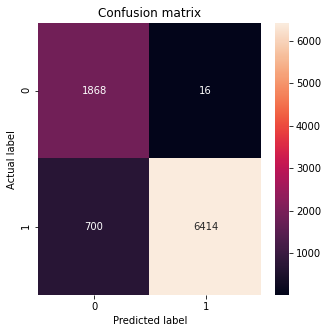

In [54]:
plot_cm(y_train_tmp, train_predictions_weighted)

### test data에 대한 confusion matrix

True Negatives:  1094
False Positives:  60
False Negatives:  675
True Positives:  3681


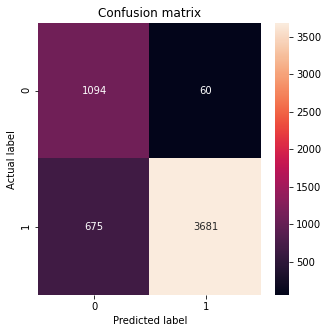

In [55]:
plot_cm(y_test, test_predictions_weighted)